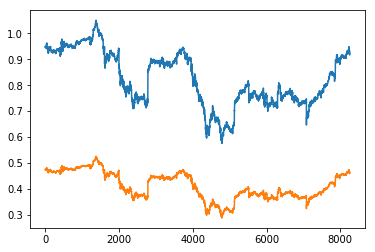

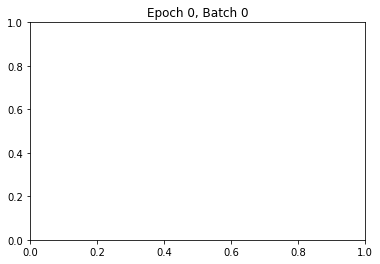

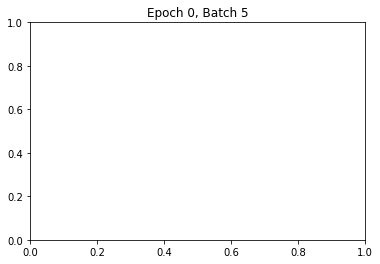

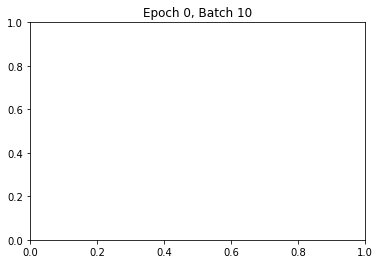

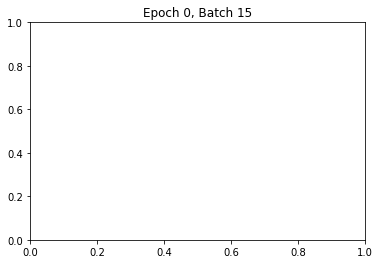

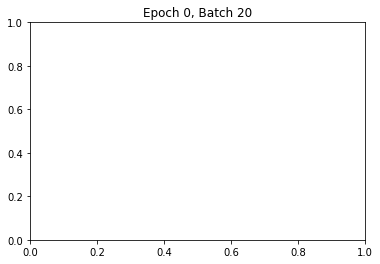

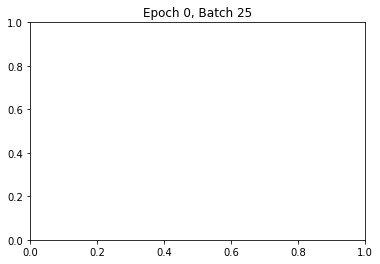

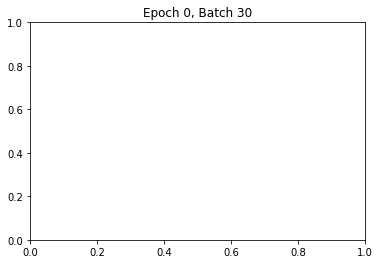

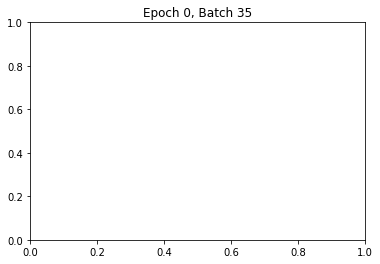

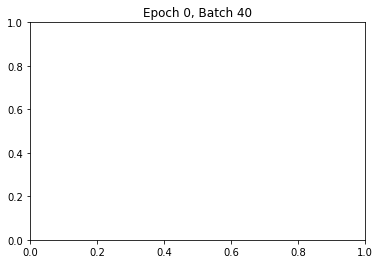

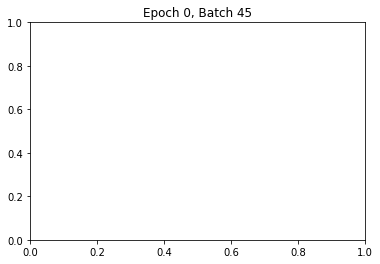

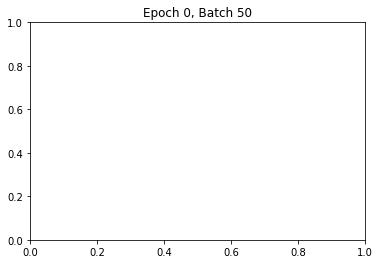

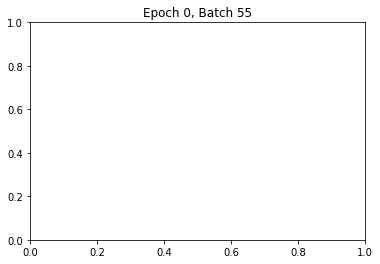

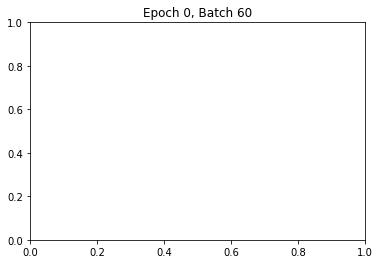

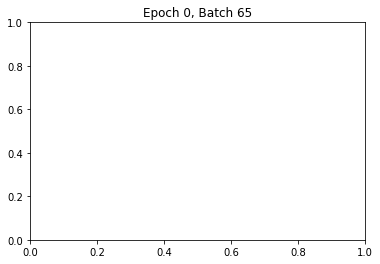

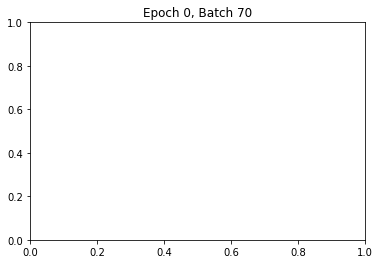

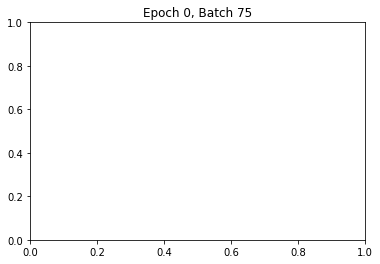

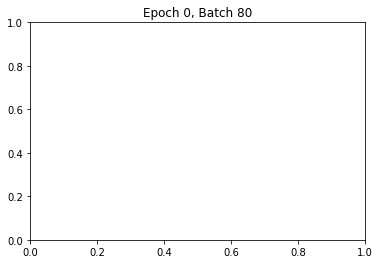

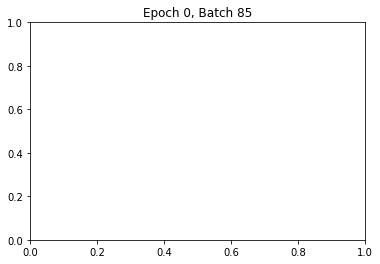

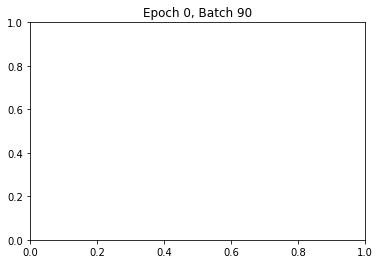

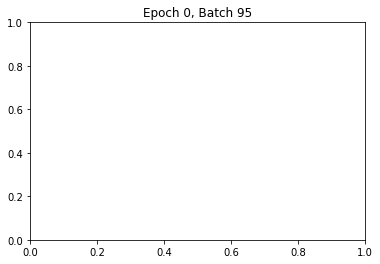

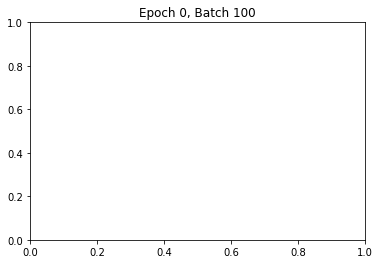

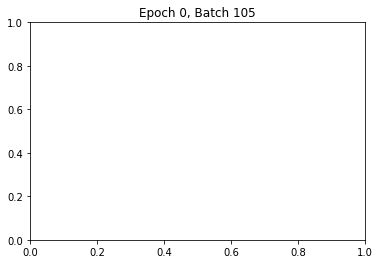

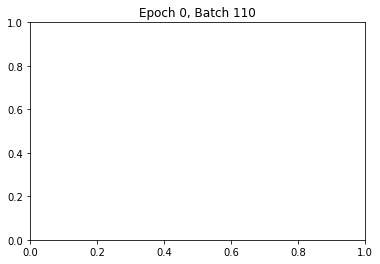

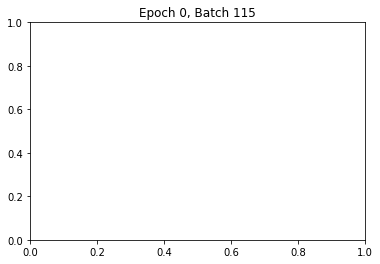

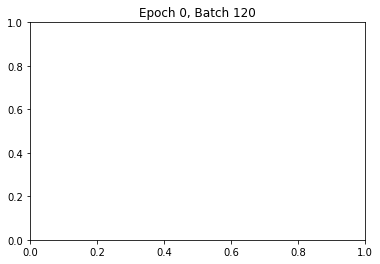

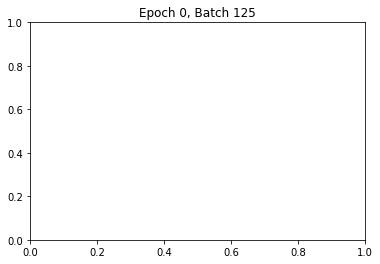

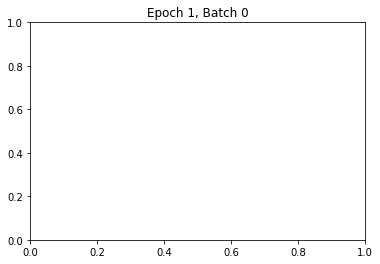

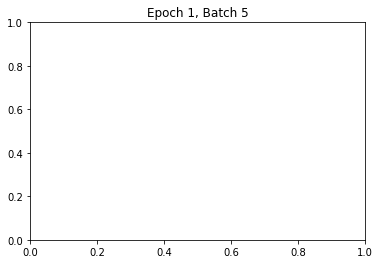

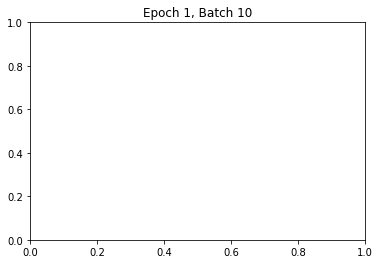

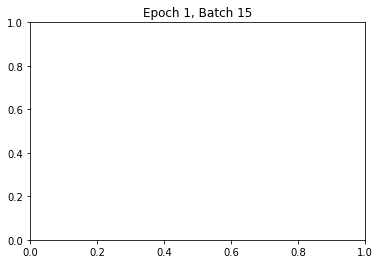

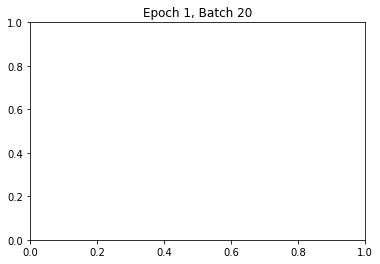

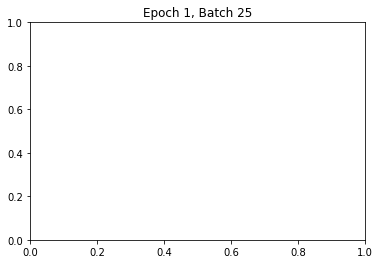

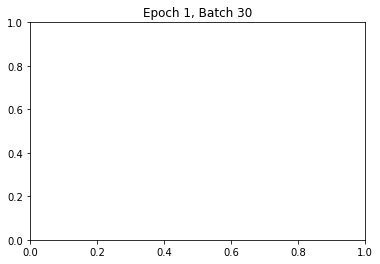

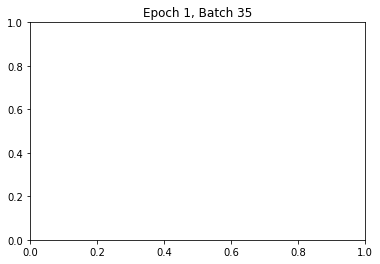

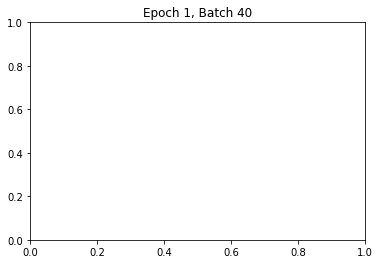

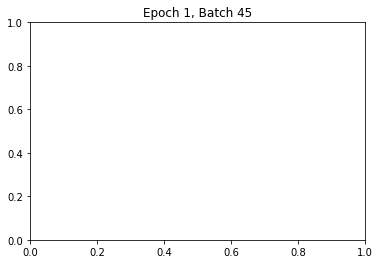

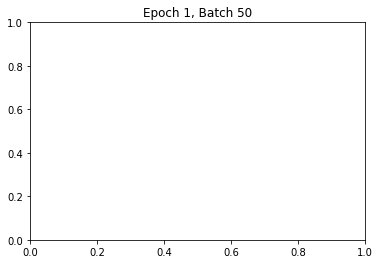

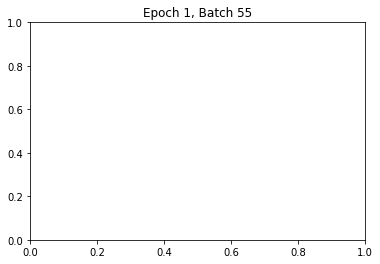

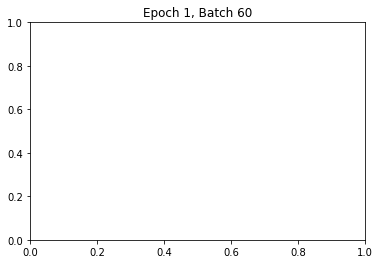

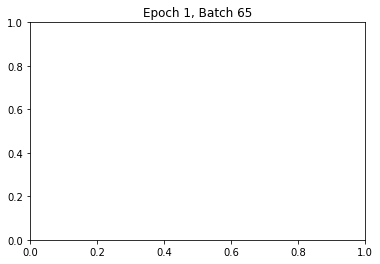

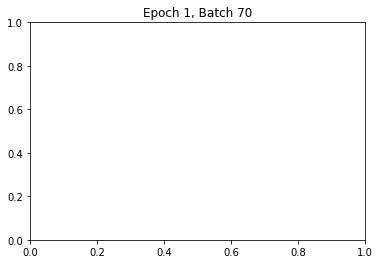

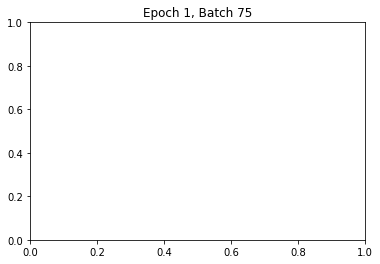

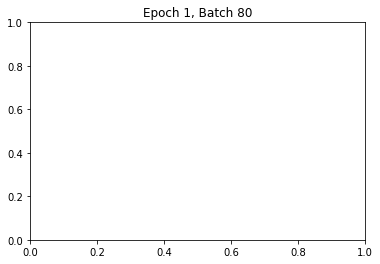

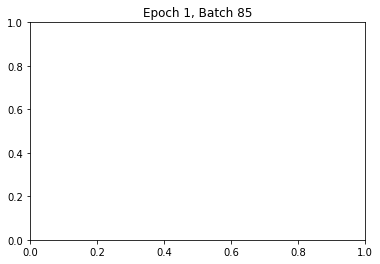

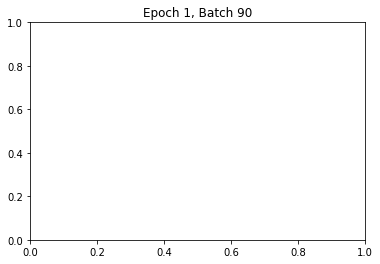

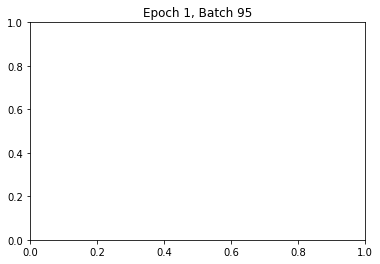

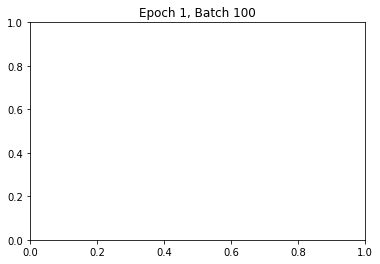

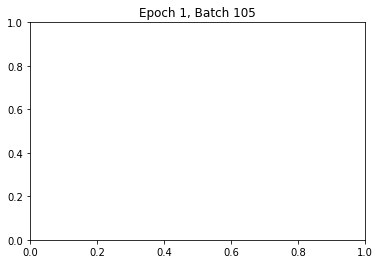

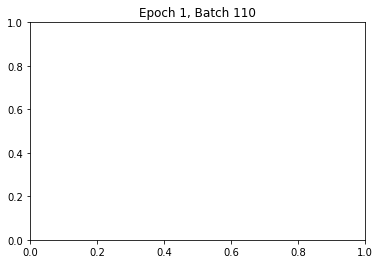

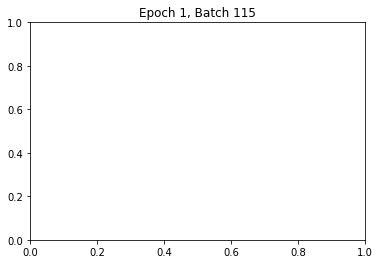

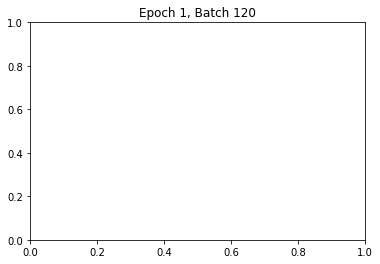

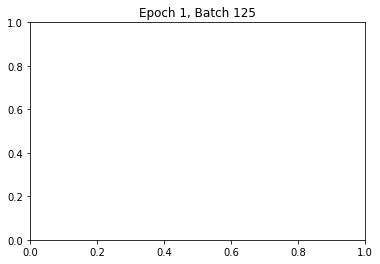

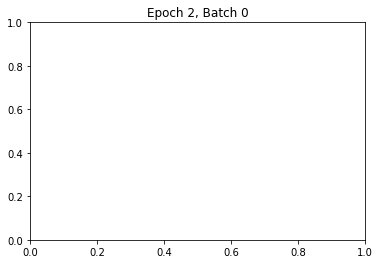

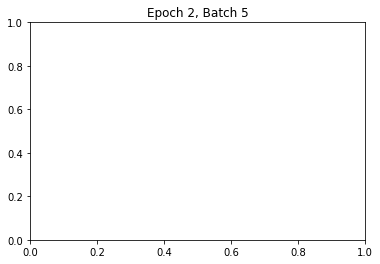

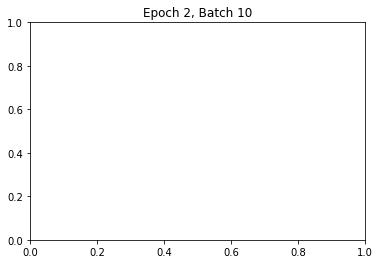

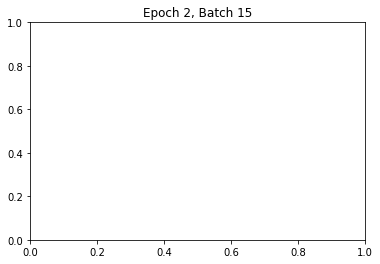

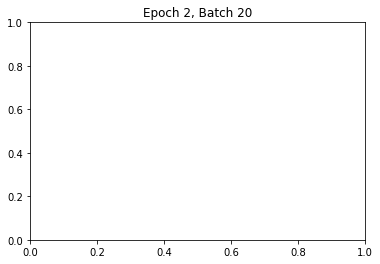

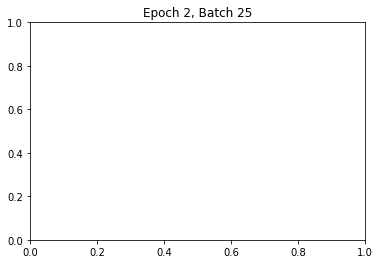

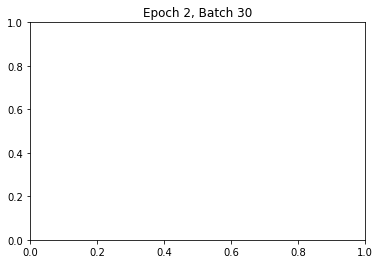

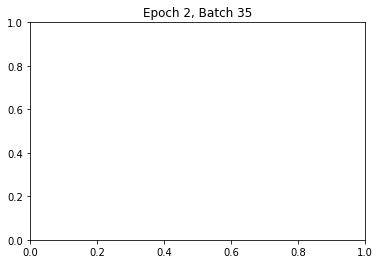

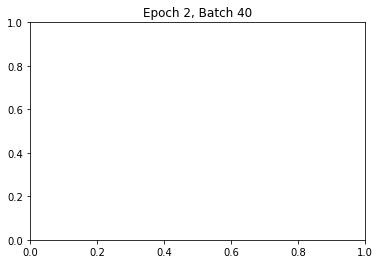

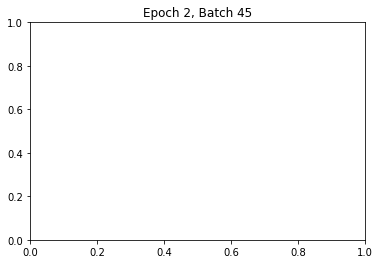

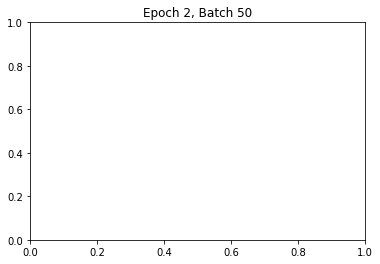

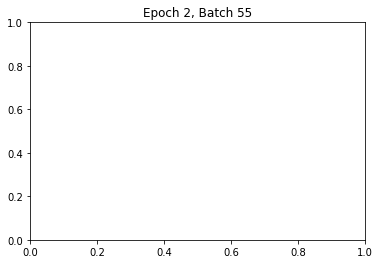

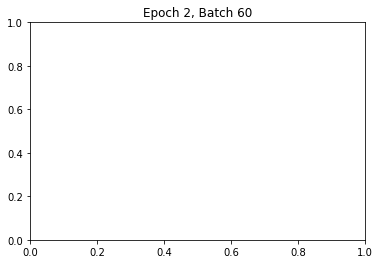

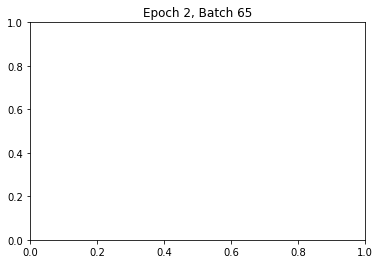

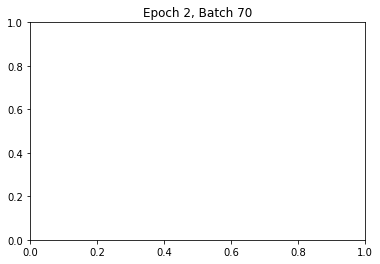

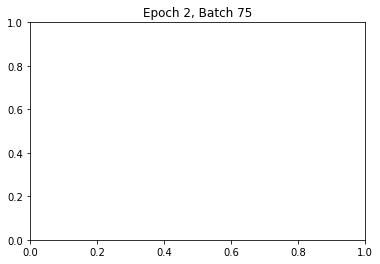

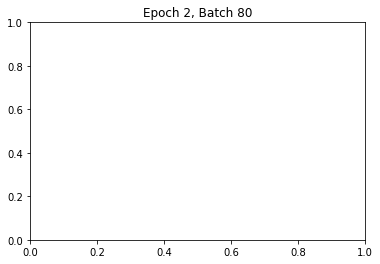

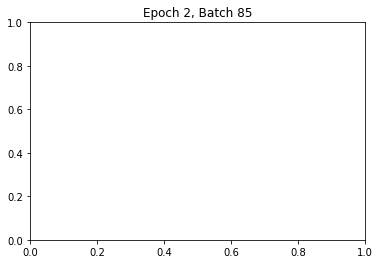

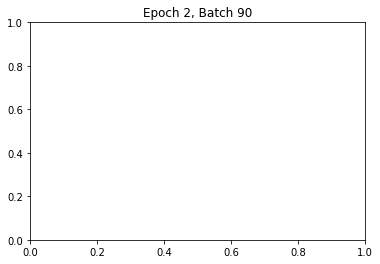

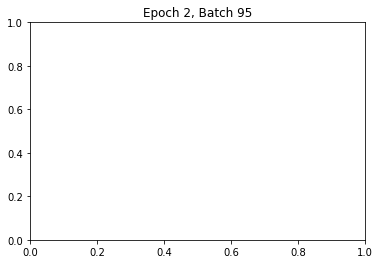

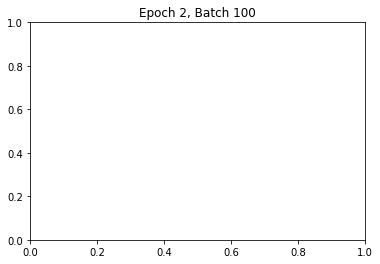

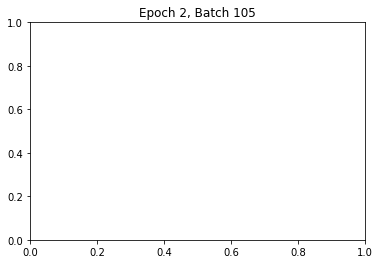

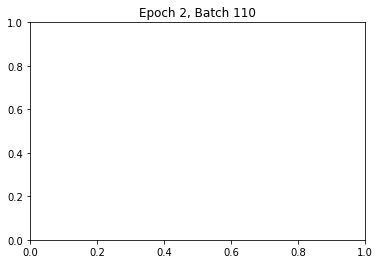

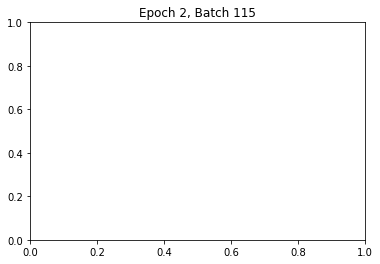

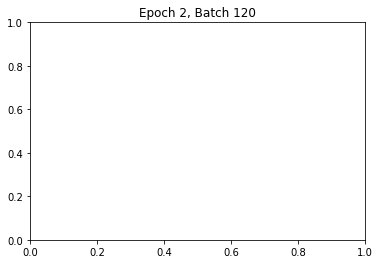

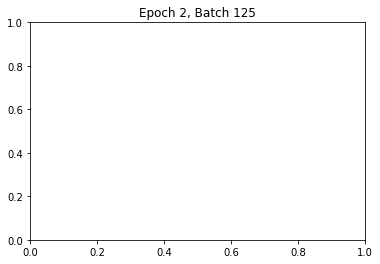

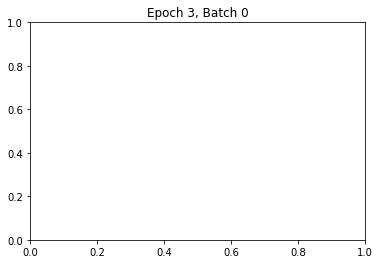

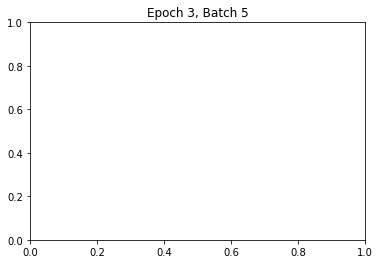

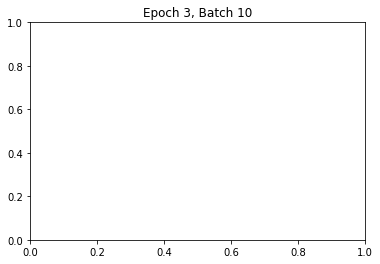

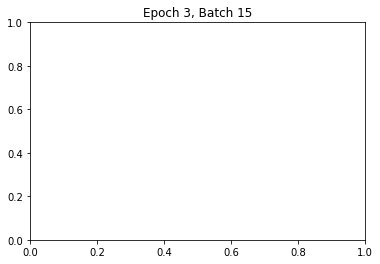

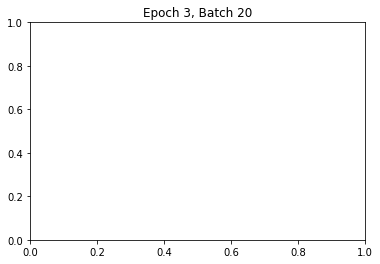

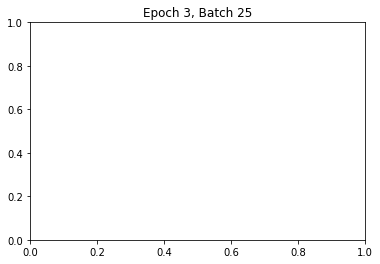

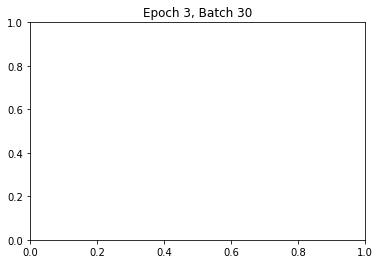

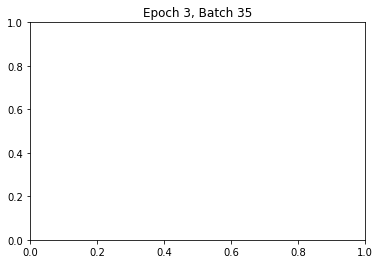

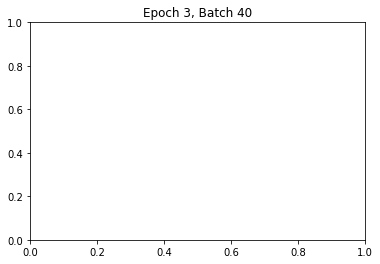

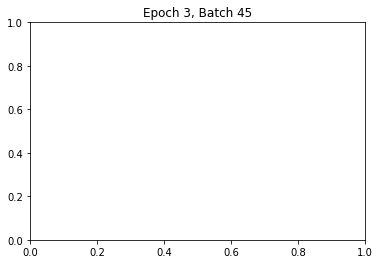

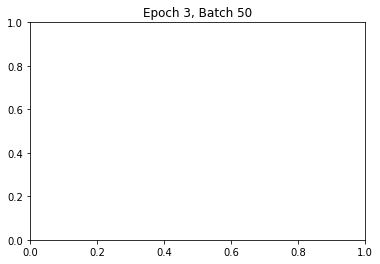

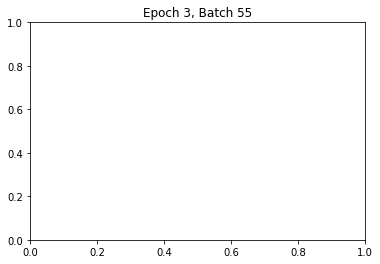

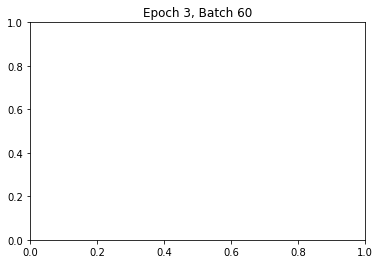

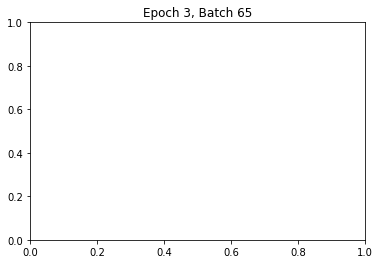

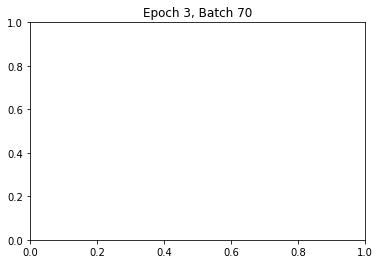

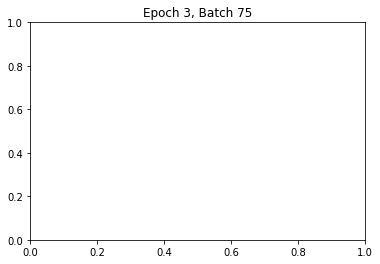

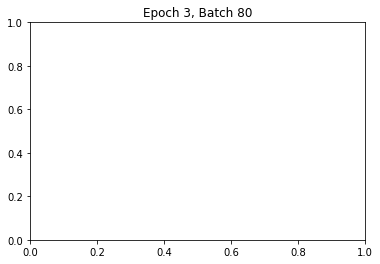

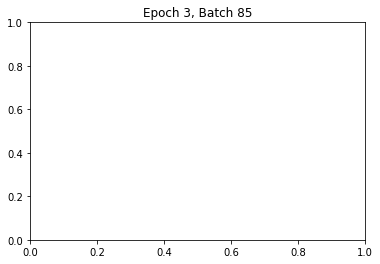

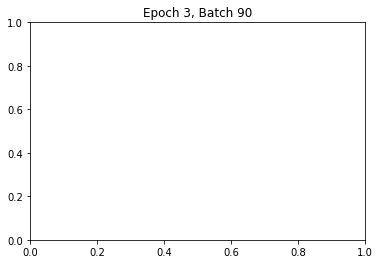

KeyboardInterrupt: 

In [2]:

# coding: utf-8

# In[86]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# In[87]:


# import data
data = pd.read_csv('data_stocks.csv')

# drop the date
data = data.drop(['DATE'], 1)

# dimensions of dataset
n = data.shape[0]
p = data.shape[1]

# make data a numpy array
data = data.values


# In[88]:


# training and testing data
train_start = 0
train_end = int(np.floor(0.8*n))
test_start = train_end
test_end = n
data_train = data[np.arange(train_start, train_end), :]
data_test = data[np.arange(test_start, test_end), :]


# In[89]:


# scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)


# In[90]:


# build X & Y
X_train = data_train[:, 1:]
y_train = data_train[:, 0]
X_test = data_test[:, 1:]
y_test = data_test[:, 0]


# In[91]:


import tensorflow as tf

# Model architecture parameters
n_stocks = 500
n_neurons_1 = 1024
n_neurons_2 = 512
n_neurons_3 = 256
n_neurons_4 = 128
n_target = 1

# Placeholder
X = tf.placeholder(dtype=tf.float32, shape=[None, n_stocks])
Y = tf.placeholder(dtype=tf.float32, shape=[None])

# Initializers
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()


# In[92]:


# Layer 1: Variables for hidden weights and biases
W_hidden_1 = tf.Variable(weight_initializer([n_stocks, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))

# Layer 2: Variables for hidden weights and biases
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))

# Layer 3: Variables for hidden weights and biases
W_hidden_3 = tf.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))

# Layer 4: Variables for hidden weights and biases
W_hidden_4 = tf.Variable(weight_initializer([n_neurons_3, n_neurons_4]))
bias_hidden_4 = tf.Variable(bias_initializer([n_neurons_4]))

# Output layer: Variables for output weights and biases
W_out = tf.Variable(weight_initializer([n_neurons_4, n_target]))
bias_out = tf.Variable(bias_initializer([n_target]))


# In[93]:


# Hidden layer
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2, W_hidden_3), bias_hidden_3))
hidden_4 = tf.nn.relu(tf.add(tf.matmul(hidden_3, W_hidden_4), bias_hidden_4))

# Output layer (must be transposed)
out = tf.transpose(tf.add(tf.matmul(hidden_4, W_out), bias_out))


# In[94]:


# Cost function
mse = tf.reduce_mean(tf.squared_difference(out, Y))

# Optimizer
opt = tf.train.AdamOptimizer().minimize(mse)


# In[95]:


# Make Session
net = tf.Session()

# Run initializer
net.run(tf.global_variables_initializer())

# Setup interactive plot
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test)
line2, = ax1.plot(y_test*0.5)
plt.show()

# Number of epochs and batch size
epochs = 10
batch_size = 256

for e in range(epochs):

    # Shuffle training data
    shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    X_train = X_train[shuffle_indices]
    y_train = y_train[shuffle_indices]

    # Minibatch training
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_x = X_train[start:start + batch_size]
        batch_y = y_train[start:start + batch_size]
        # Run optimizer with batch
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})

        # Show progress
        if np.mod(i, 5) == 0:
            # Prediction
            pred = net.run(out, feed_dict={X: X_test})
            line2.set_ydata(pred)
            plt.title('Epoch ' + str(e) + ', Batch ' + str(i))
            file_name = 'epoch_' + str(e) + '_batch_' + str(i) + '.jpg'
            plt.savefig(file_name)
            plt.pause(0.01)

# Print final MSE after Training
mse_final = net.run(mse, feed_dict={X: X_test, Y: y_test})
print(mse_final)

